# Задача 11

Найти уровень энергии и волновую функцию $\psi(x)$ основного состояния в потенциальной яме $U(x)$, решая конечномерный аналог спектральной задачи для одномерного стационарного уравнения Шрёдингера

$$(-\frac{1}{2}\frac{\partial^2}{\partial x^2} + U(x) - E)\psi(x, t) = 0, \;\; |\psi(x)| \rightarrow 0 \; при \; |x| \rightarrow \infty$$ 

Для поиска наименьшего собственного значения $\hat H \vec{\psi} = E_0 \vec{\psi}$ трехдиагональной матрицы $\hat H$ использовать метод обратных итераций.

Проверить работу программы, сравнив с точным решением для $U(x) = \frac{1}{2}x^2$

## Решение: 

In [1]:
import math
import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt

### Аналитическое решение

Уравнение  $\hat H \vec{\psi} = E_0 \vec{\psi}$ - стационарное, значит и решение тоже.

Потенциал осциллятора: 

$$U(x) = \frac{m\omega^2x^2}{2}, \;\; \\
m = 1, \; \omega = 1, \; \hbar = 1$$

Основное состояние: 

$$E_0 = \frac{h\omega}{2} = \frac{1}{2}$$

$$\psi_0(x) = (\frac{m\omega}{\pi \hbar})^{1/4} \exp{(-\frac{m\omega x^2}{2\hbar})} = (\frac{1}{\pi})^{1/4}\exp{(-\frac{x^2}{2})}$$

In [2]:
def psi0_analytical(x):
    return (1/math.pi)**(1/4) * math.exp(-0.5*(x**2))

In [3]:
E0_sol = 1/2
x_start = -10
x_end = 10
N = 150

h = (x_end - x_start) / N

x_s_sol = []
psi0_sol = []

for i in range(N):
    x_s_sol.append(x_start + i * h)
    psi0_sol.append(psi0_analytical(x_s_sol[i]))
    
# нормировать на 1
sol_norm = sla.norm(psi0_sol)
psi0_sol = [psi0_sol[i] / sol_norm for i in range(len(psi0_sol))]

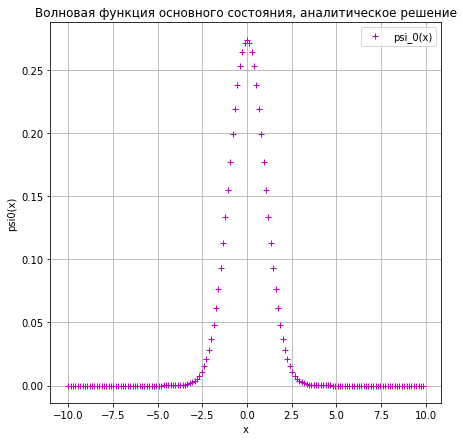

In [4]:
plt.figure(figsize=(7,7))
plt.plot(x_s_sol, psi0_sol, 'm+', label="psi_0(x)")
plt.grid()
plt.title('Волновая функция основного состояния, аналитическое решение')
plt.xlabel('x')
plt.ylabel('psi0(x)')
plt.legend()
plt.show()

### Численное решение:

Уравнение:

$$-\frac{1}{2}\frac{\partial^2}{\partial x^2} + \frac{x^2}{2} = E_0\psi(x)$$

Если переписать вторую производную через конечную разность:

$${\psi}_i'' =\frac{\psi_{i-1} - 2\psi_i + \psi_{i+1}}{h^2}$$

То уравнение в одной точке: 

$$\frac{-\psi_{i-1}}{2h^2} +(\frac{1}{h^2}+\frac{x_i^2}{2})\psi_i + \frac{\psi_{i+1}}{2h^2} = E_0\psi_i$$

В матричном виде $H\vec{\psi} = E_0\vec{\psi}$ матрица $H$ в левой части будет трехдиагональной, следовательно для решения можно будет использовать метод прогонки: 

$$H = 
\begin{pmatrix}
\frac{1}{h^2}+\frac{x_1^2}{2} & \frac{-1}{2h^2} & 0 & ... & 0 & 0 & 0\\ 
\frac{-1}{2h^2} & \frac{1}{h^2}+\frac{x_2^2}{2} & \frac{-1}{2h^2} & ... & 0 & 0 & 0\\ 
... & ... & ... & ... & ... & ... & ...\\ 
0 & 0 & 0 & ... & \frac{-1}{2h^2} & \frac{1}{h^2}+\frac{x_{N-1}^2}{2} & \frac{-1}{2h^2}\\ 
0 & 0 & 0 & ... & 0 & \frac{-1}{2h^2} & \frac{1}{h^2}+\frac{x_N^2}{2}
\end{pmatrix}
$$

In [5]:
def U(x):
    return (x**2)/2

In [6]:
def make_matrix(N, x_start, x_end):
    
    h = (x_end - x_start)/N
    
    a = []
    b = []
    c = []
    
    for i in range(0, N):
        xi = x_start + i*h
        a.append(-0.5/(h**2))
        b.append(1/(h**2) + U(xi))
        c.append(-0.5/(h**2))
        
    a[0] = 0
    c[N-1] = 0
    
    A = [a, b, c]
    
    return A

### Метод итераций

Степенной метод находит наибольшее собственное значение, а мы ищем основное состояние - наименьшую энергию - наименьшее собственное значение. Рассмотрим обратную матрицу, так как ее собственные значение будут обратными величинами к собственным значениям исходной матрицы.

"Прямой" метод: 

Если расположить собственные числа в порядке возрастания, т.е. $E_1$ - максимальное, то: 

Возьмем произвольный вектор $\psi^{(0)} = \sum{a_i\psi_i}, \;\; \psi_i$ собственные вектора матрицы.

Тогда итерационный процесс, при котором этот произвольный вектор каждый раз умножается на нашу матрицу $\hat H$ будет сходиться к собственному вектору $\psi_1$, соответсвующему наибольшему собственному значению $E_1$: 

$$\psi^{(k)} = \hat H \psi^{(k-1)} \;\; \rightarrow \;\; \psi_1$$

Но: нам необходимо наименьшее собственное значение. Оно же - наибольшее собственное значение для обратной матрицы $\hat H^{-1}$. Тогда итерационный процесс: 

$$\psi^{(k)} = \hat H^{-1} \psi^{(k-1)}$$

Или: 

$$\hat H \psi^{(k)} = \psi^{(k-1)}$$

Итерационный процесс обратный - "поднимаемся" от последнего - метод прогонки!

Собственное значение в таком случае: 

$$E_0 = \frac{1}{\lambda_{max}} = \frac{\left \|\psi^{[k-1]}  \right \|}{\left \|\psi^{[k]}  \right \|}$$

Метод прогонки для трехдиагональной матрицы: 

In [7]:
def solve_3diag(A, d, N):
    # A = [a, b, c]

    d_new = d.copy()
    b_new = A[1].copy()
    c_new = A[2].copy()
    a_new = A[0].copy()

    for i in range(0, N):
        k = a_new[i] / b_new[i - 1]
        b_new[i] -= k * c_new[i - 1]
        d_new[i] -= k * d_new[i - 1]
        #print(d_new[i])
    y = [i for i in range(N)]

    y[N - 1] = d_new[N - 1] / b_new[N - 1]

    for i in range(N - 2, -1, -1):
        y[i] = (d_new[i] - c_new[i] * y[i + 1]) / b_new[i]

    return y

### Вычисления: 

Границы и разбиение интервала:

In [8]:
x_s = [(x_start + i*h) for i in range(N)]

In [9]:
H = make_matrix(N, x_start, x_end)  # трехдиагональная матрица
def vector():
    psi_next_ = [1 for i in range(N)]
    psi_next_[0]=0
    psi_next_[N-1] = 0
    return psi_next_
psi_next = vector()
print(len(psi_next))# как начальный случайный вектор возьму просто N точек от 0 до 1
psi_prev = psi_next

150


In [10]:
K=1
for i in range(1,10):
    for k in range(0, K):
        psi_prev = psi_next
        psi_next = solve_3diag(H, psi_prev, N)

    E0 = sla.norm(psi_prev) / sla.norm(psi_next)
    print("K=",K,"\t","errE_0=",abs((E0_sol-E0)/E0_sol))
    K+=1

K= 1 	 errE_0= 1.3236796588274444
K= 2 	 errE_0= 0.0006905077910545065
K= 3 	 errE_0= 0.001112324854392388
K= 4 	 errE_0= 0.0011123498144961497
K= 5 	 errE_0= 0.0011123498145609867
K= 6 	 errE_0= 0.0011123498145613198
K= 7 	 errE_0= 0.0011123498145608757
K= 8 	 errE_0= 0.0011123498145610977
K= 9 	 errE_0= 0.0011123498145609867


In [11]:
psi0_norm = sla.norm(psi_next)
psi0 = [psi_next[i] / psi0_norm for i in range(len(psi_next))]

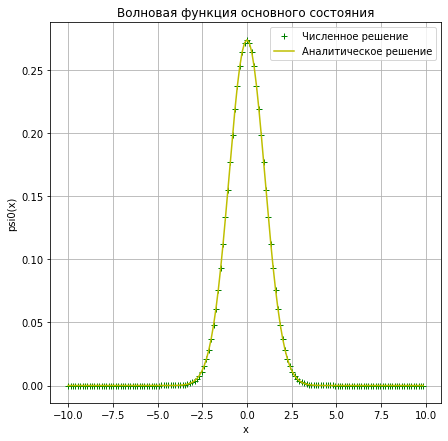

In [12]:
plt.figure(figsize=(7,7))
plt.plot(x_s, psi0, 'b+', label="Численное решение")
plt.plot(x_s, psi0_sol, 'm', label="Аналитическое решение")
plt.grid()
plt.title('Волновая функция основного состояния')
plt.xlabel('x')
plt.ylabel('psi0(x)')
#plt.yscale('log')
plt.legend()
plt.show()

### Ошибки:

In [24]:
print("Вычисленное E_0 = \t",E0)
print("Аналитическое E_0 \t", E0_sol)
print("E0_analytic -  E_0 = \t",abs((E0_sol - E0)/E0_sol))
err = [abs(psi0[i] - psi0_sol[i]) for i in range(len(x_s))]

Вычисленное E_0 = 	 0.4994438250927195
Аналитическое E_0 	 0.5
E0_analytic -  E_0 = 	 0.0011123498145609867


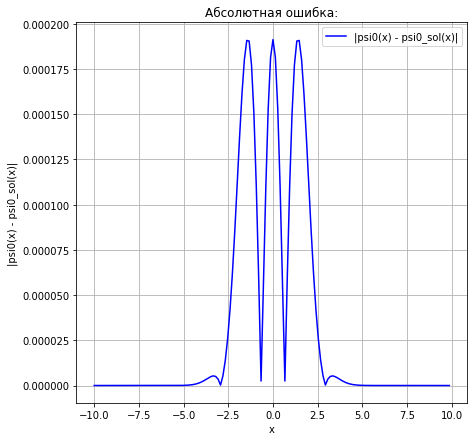

In [25]:
plt.figure(figsize=(7,7))
plt.plot(x_s, err, 'b', label="|psi0(x) - psi0_sol(x)|")
plt.grid()
plt.title('Абсолютная ошибка:')
plt.xlabel('x')
plt.ylabel('|psi0(x) - psi0_sol(x)|')
#plt.yscale('log')
plt.legend()
plt.show()

Посмотрим ошибки в вычислении разделенных разностей: 

$$\frac{y(x-h) - 2y(x) + y(x+h)}{h^2} = y''(x) + \frac{h^2}{12}y^{(iv)}(x)$$

$$\frac{h^2}{12} (\frac{1}{\pi})^{1/4} e^{-\frac{x^2}{2}} (x^4 - 6x^2 + 3)$$

In [19]:
def o(x):
    return abs((h**2/12)*(1/math.pi)**(1/4)*math.exp(-1*(x**2)/2)*(x**4 - 6*x**2 + 3))

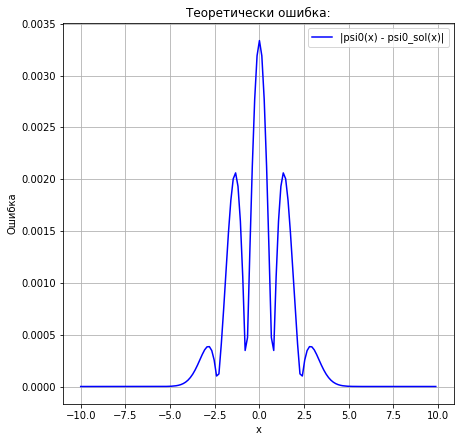

In [20]:
plt.figure(figsize=(7,7))
plt.plot(x_s, [o(x) for x in x_s], 'b', label="|psi0(x) - psi0_sol(x)|")
plt.grid()
plt.title('Теоретически ошибка:')
plt.xlabel('x')
plt.ylabel('Ошибка')
plt.legend()
plt.show()